# CS5672 Project Notebook - Neural Radiance Fields (NeRF)

Welcome to the Project Notebook! In this project, you will learn:

1. Basic usage of the PyTorch deep learning library
2. How to understand and build neural network models in PyTorch
3. How to build a Neural Radiance Field [NeRF](https://arxiv.org/abs/2003.08934) from a set of images
4. How to synthesize novel views from a NeRF

If this is your first time working with PyTorch, **please go through the "What is PyTorch" and "Neural Networks" tutorials in [Deep Learning with PyTorch: A 60 Minute Blitz](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)**. It won't take too long, but you will learn a lot and it will make this assignment much easier. You can use a new Colab notebook for the tutorials.

# Initialization
Run the cell below to import the necessary libaries and print the device that the code will be run on (GPU vs.CPU).
By default, you should get a GPU (i.e., the output is `cuda`).

In [23]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import imageio
import time
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Student TODO implementation 1: Fitting a single image with positional encoding



## TODO 1(a): Positional encoding
In class, we learned that standard coordinate-based MLPs cannot natively represent high-frequency functions on low-dimensional domains.
To better preserve high frequency variation in the data, we can encode each of the scalar input coordinates with a sequence of sinusoids with exponentially increasing frequencies before passing them into the network.

Given a coordinate $𝐱$, we map each coordiante value $p$ in $𝐱$ with the encoding function $\gamma(⋅)$ as below:
$$γ(p)=(\text{sin}(2^0πp), \text{cos}(2^0πp), \text{sin}(2^1πp), \text{cos}(2^1πp), \cdots, \text{sin}(2^{L-2}πp), \text{cos}(2^{L-2}πp), \text{sin}(2^{L-1}πp), \text{cos}(2^{L-1}πp))$$
where the dimension of the output $γ(p)$ is $2L$.

If the input is a 2D coordinate $𝐱=(p_1,p_2)$, after positional encoding we will get a long vector with dimension $4L$:
$$(\text{sin}(2^0πp_1), \text{sin}(2^0πp_2), \text{cos}(2^0πp_1), \text{cos}(2^0πp_2), \text{sin}(2^1πp_1), \text{sin}(2^1πp_2), \text{cos}(2^1πp_1), \text{cos}(2^1πp_2), \cdots, \text{sin}(2^{L-2}πp_1), \text{sin}(2^{L-2}πp_2), \text{cos}(2^{L-2}πp_1), \text{cos}(2^{L-2}πp_2), \text{sin}(2^{L-1}πp_1), \text{sin}(2^{L-1}πp_2), \text{cos}(2^{L-1}πp_1), \text{cos}(2^{L-1}πp_2))$$

Similarly you can encode a 3D coordinate or an input signal of any dimension.

In [24]:
def positional_encoding(x, num_frequencies=6, incl_input=True):
  r"""Apply positional encoding to the input.

  Args:
    x (torch.Tensor): Input tensor to be positionally encoded.
      The dimension of x is [N, D], where N is the number of input coordinates,
      and D is the dimension of the input coordinate.
    num_frequencies (optional, int): The number of frequencies used in
     the positional encoding default: 6).
    incl_input (optional, bool): If True, concatenate the input with the
        computed positional encoding (default: True).

  Returns:
    (torch.Tensor): Positional encoding of the input tensor.
  """
  results = []
  if incl_input:
    results.append(x)
  #############################  TODO 1(a) BEGIN  ############################
  # encode input tensor and append the encoded tensor to the list of results.
  debug = False
  if debug:
    print(f'x ({x.shape}): {x} \n'\
            f'num_frequencies: {num_frequencies} \n'\
            f'include input: {incl_input}\n')

  # normalize (depends on if necessary)
  if (torch.max(x) > 1 or torch.min(x) < -1):
    if debug:
        print("Input not normalized")

  # define frequencies to apply
  freqs = torch.pow(2, torch.arange(num_frequencies)) * np.pi
  f_view = freqs.view(1, 1, num_frequencies)

  # apply function gamma
  x_broadcast = x.unsqueeze(-1)
  if x_broadcast.device != f_view.device:
    f_view = f_view.to(x_broadcast.device)
  x_in = x_broadcast * f_view

  sin_x = torch.sin(x_in).transpose(1,2) # group by frequency not by pixel dim
  cos_x = torch.cos(x_in).transpose(1,2)

  # compile answer
  x_combined = torch.cat((sin_x, cos_x), dim=-1)
  x_out = x_combined.flatten(start_dim=1)
  results.append(x_out)


  #############################  TODO 1(a) END  ##############################
  return torch.cat(results, dim=-1)

### Test case for TODO 1
test function `positional_encoding()`

In [25]:
THRESH = 1e-2
if not os.path.exists("positional_encoding_test_0.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/positional_encoding_test_0.npz
if not os.path.exists("positional_encoding_test_1.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/positional_encoding_test_1.npz

def test_positional_encoding(test_file):
    test_data = np.load(test_file)
    coordinates = torch.from_numpy(test_data['coordinates'])
    embedded_coordinates = positional_encoding(coordinates, num_frequencies=int(test_data['num_frequencies']))
    error_coordinates = np.mean((test_data['embedded_coordinates'] - embedded_coordinates.numpy())**2)
    assert error_coordinates < THRESH
    print("Passed!")

test_positional_encoding("positional_encoding_test_0.npz")
test_positional_encoding("positional_encoding_test_1.npz")

Passed!
Passed!


## TODO 1(b): 2D Image Fitting

Now, let's try to fit a 2D image with a multilayer perceptron (MLP)!
In class we learn that we can store an 2D image with a coordinate-based MLP (as shown in the figure below). The input to this MLP is 2D pixel coordinate (x, y) as a pair of floating point numbers, and the output is RGB color of the corresponding pixel. This is a simple supervised learning problem, and we can just use simple gradient descent to train the network weights and see what happens.  

<!-- ![1650569617136.jpg]() -->
<div>
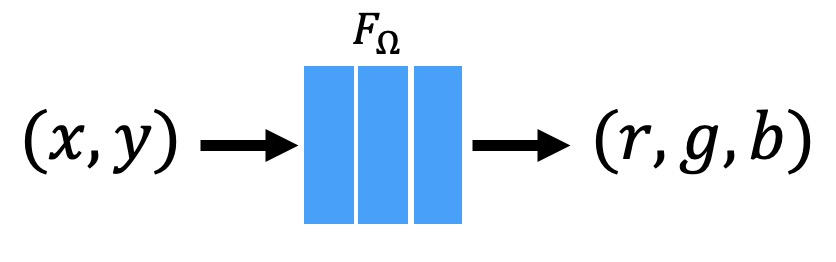
</div>

First, let's define the network architecture for this 2D fitting task.
Please complete the `Model2d` code below, which takes in a positional-encoded 2D pixel coordinate and outputs a 3D RGB color value corresponding to that pixel. The model should be a fully connected neural network (MLP) consisting of several fully-connected layers with the following specifications:
- Input layer: project the positional-encoded 2D pixel coordinate to the hidden dimension (`filter_size`).
- Several hidden layers.
- Output layer: project the final hidden dimension to a 3D RGB color value.
- Activation functions: use ReLU for input and hidden layers, and sigmoid for the output layer to ensure the RGB color is $(0, 1)$.

After defining the model, you can run all the way to the last cell in TODO 1(b) to execute the training process. With an MLP architecture with one hidden layer of dimension 128, you should get PSNR* $\approx$ 27 after training for 10,000 iterations.

Next, your task is to modify `Model2d`, such that **after training for 10,000 iterations with num_encoding_functions=6, PSNR is greater than or equal to 30**. Please do not change the model name, the name of the existing arguments, or the input/output dimensions. Hint: You can try different model structure (e.g. more/fewer layers, smaller/bigger hidden dimensions).

*[PSNR](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) is an image quality measurement. Higher PSNR generally indicates that the reconstruction is of higher quality.

In [26]:
class Model2d(nn.Module):
  r"""Define a 2D model comprising fully connected layers.
  """
#   #############################  TODO 1(b) BEGIN  ############################
  def __init__(self, filter_size=128, num_hidden=1, num_frequencies=6):
    super().__init__()
    in_dim = 2 * (2 * num_frequencies + 1) # +1 only if using incl_input right?
    out_dim = 3

    # first layer
    layers = [
        nn.Linear(in_dim, filter_size),
        nn.ReLU()
    ]

    # hidden layers
    for _ in range(num_hidden):
        layers.extend([
            nn.Linear(filter_size, filter_size),
            nn.ReLU()
        ])

    # last layer
    layers.extend([
        nn.Linear(filter_size, out_dim),
        nn.Sigmoid()
    ])

    self.mlp = nn.Sequential(*layers) # unpack all layers into MLP


  def forward(self, x):
    return self.mlp(x)
#   #############################  TODO 1(b) END  ##############################

## TODO 1(c): Training `Model2d` to fit the 2D image

With the `Model2d` defined previously, we can now train a model to fit the input 2D image. Please complete the following training code, including 2 missing steps:
1. Generate the 2D pixel coordinates and positional encode them as the input to the model.
    - Before positional encoding, the pixel coordinates should be normalized to the range $[-1, 1]$.
2. During each training iteration, compute the loss between the model's output RGB values and the ground truth image (use MSE loss), and update the model parameters using backpropagation.

***Note: You should NOT use `for` loops to generate pixel coordinates. Use Vectorized operations like `torch.meshgrid` instead!***

In [27]:
# Download image
if not os.path.exists('Starry-Night-canvas-Vincent-van-Gogh-New-1889_12.jpg'):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/Starry-Night-canvas-Vincent-van-Gogh-New-1889_12.jpg

# Load painting image
painting = imageio.imread("Starry-Night-canvas-Vincent-van-Gogh-New-1889_12.jpg")
painting = torch.from_numpy(np.array(painting, dtype=np.float32)/255.).to(device)
height_painting, width_painting = painting.shape[:2]

"""
Parameters for 2D network training
"""

def train_2d_model(model=Model2d, num_frequencies=6, height=height_painting, width=width_painting, testimg=painting):

  # Optimizer parameters
  lr = 5e-4
  num_iters = 10000

  # Misc parameters
  display_every = 2000  # Number of iters after which stats are displayed

  """
  Model
  """
  model2d = model(num_frequencies=num_frequencies)
  model2d.to(device)

  def weights_init(m):
    if isinstance(m, nn.Linear):
      torch.nn.init.xavier_uniform_(m.weight)

  model2d.apply(weights_init)

  """
  Optimizer
  """
  optimizer = torch.optim.Adam(model2d.parameters(), lr=lr)

  """
  Train-Eval-Repeat!
  """
  # Seed RNG, for repeatability
  seed = 5670
  torch.manual_seed(seed)
  np.random.seed(seed)

  # Lists to log metrics etc.
  psnrs = []
  iternums = []

  t = time.time()
  t0 = time.time()

  #############################  TODO 1(c) BEGIN  ############################
  # Generate 2D Pixel Coordinates. DO NOT use for loops!

  # get coords
  coords_y, coords_x = torch.meshgrid(
      torch.arange(height_painting), torch.arange(width_painting), indexing='ij'
  )

  # normalize coords, h:[0,H) w:[0,W) -> ([-1, 1], [-1,1])

  # might be able to use 1 actually since all values will be in [0,2] anyway
  center_y, center_x = height_painting/2, width_painting/2

  norm_y = (2 * coords_y / (height_painting - 1)) - 1.0
  norm_x = (2 * coords_x / (width_painting - 1)) - 1.0
  norm_coords = torch.stack((norm_x, norm_y), dim=-1)
  encoding_input = norm_coords.view(-1,2)

  # get encodings
  encodings = positional_encoding(encoding_input,
                                  num_frequencies=num_frequencies)


  # send everything to cuda
  encodings = encodings.to(device)

  # Training loop
  for i in range(num_iters+1):
    # Training iteration

    # forward pass
    pred = model2d.forward(encodings)
    # print(f'pred: {pred.shape}')
    # print(f'test: {testimg.shape}')
    loss = F.mse_loss(pred, testimg.view(-1,3))

    # backwards pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  #############################  TODO 1(c) END  ############################
    # Display images/plots/stats
    if i % display_every == 0:
      psnr = -10. * torch.log10(loss)
      print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f" % psnr.item(), \
            "Time: %.2f secs per iter" % ((time.time() - t) / display_every), "%.2f secs in total" % (time.time() - t0))
      t = time.time()

      psnrs.append(psnr.item())
      iternums.append(i)

      plt.figure(figsize=(13, 4))
      plt.subplot(131)
      plt.imshow(pred.detach().cpu().numpy())
      plt.title(f"Iteration {i}")
      plt.subplot(132)
      plt.imshow(testimg.cpu().numpy())
      plt.title("Target image")
      plt.subplot(133)
      plt.plot(iternums, psnrs)
      plt.title("PSNR")
      plt.show()

  print('Done!')

/tmp/ipython-input-1878077472.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  painting = imageio.imread("Starry-Night-canvas-Vincent-van-Gogh-New-1889_12.jpg")


### Try training!

Iteration 0  Loss: 0.0457  PSNR: 13.40 Time: 0.00 secs per iter 0.01 secs in total


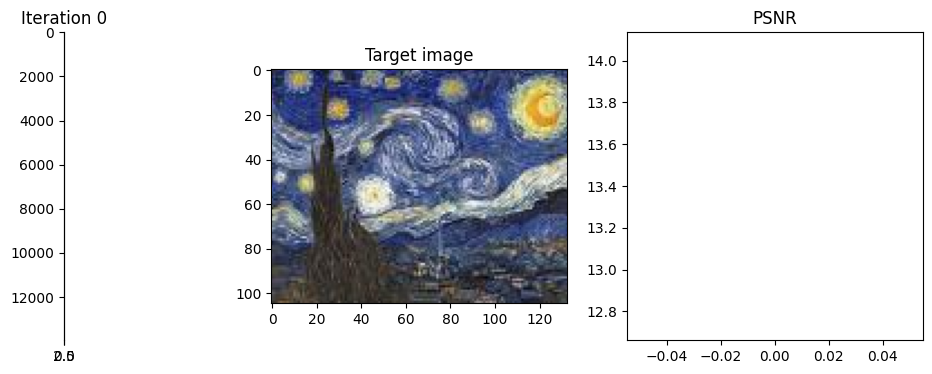

Iteration 2000  Loss: 0.0025  PSNR: 26.07 Time: 0.00 secs per iter 3.46 secs in total


Iteration 4000  Loss: 0.0016  PSNR: 27.91 Time: 0.00 secs per iter 6.68 secs in total


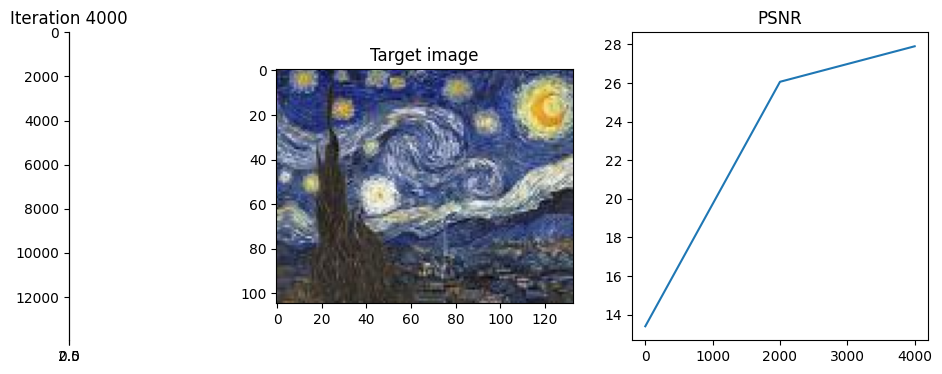

Iteration 6000  Loss: 0.0013  PSNR: 28.95 Time: 0.00 secs per iter 9.81 secs in total


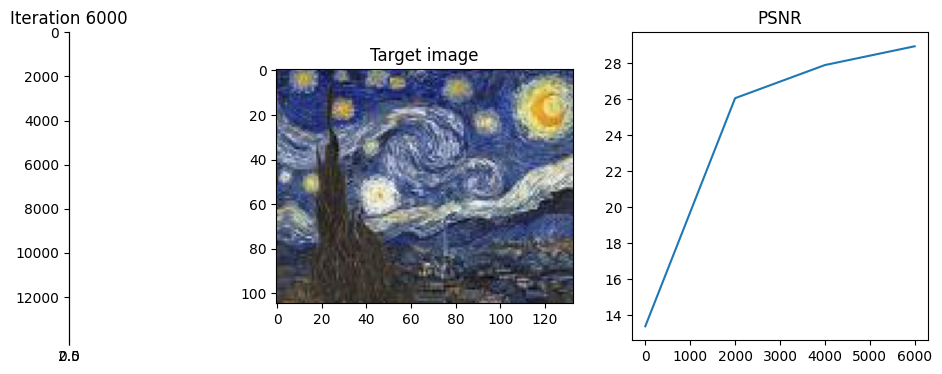

Iteration 8000  Loss: 0.0011  PSNR: 29.63 Time: 0.00 secs per iter 13.04 secs in total


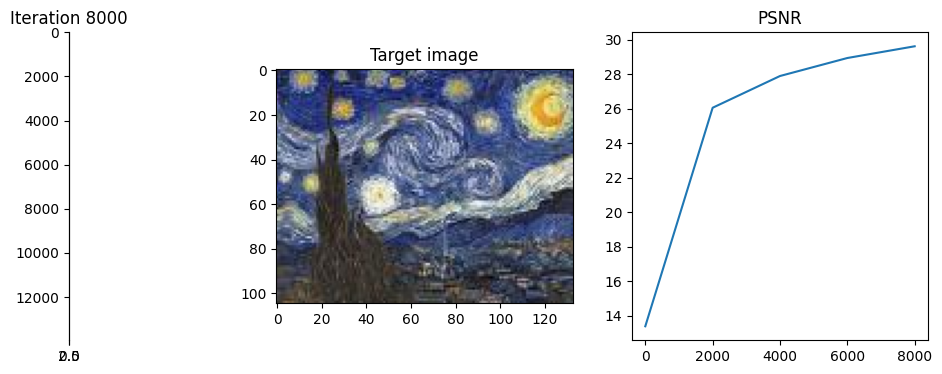

Iteration 10000  Loss: 0.0010  PSNR: 30.11 Time: 0.00 secs per iter 16.36 secs in total


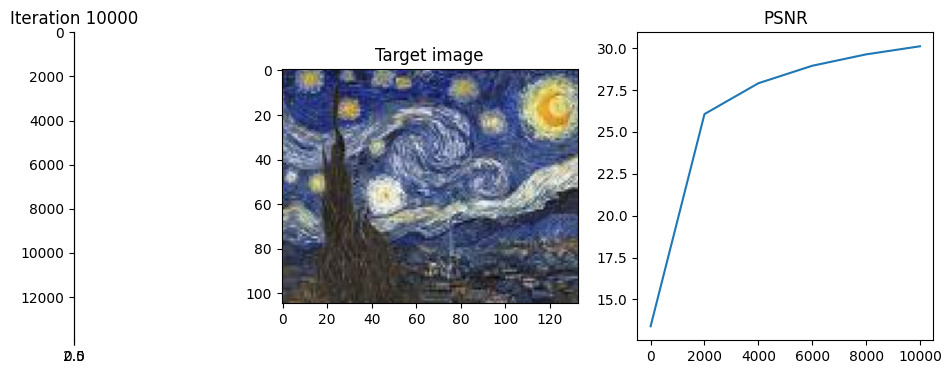

Done!


In [28]:
# with positional encoding at frequency=6
train_2d_model(model=Model2d, num_frequencies=6)

## TODO 1(d): write down your answer in this cell
### Question:
Try runnng the same training procedure `train_2d_model`, but without positional encoding (i.e., num_frequencies=0), or with different number of frequencies and see what happens. What's the effect of positional encoding and the effect of different numbers of frequencies?
### Answer: Write down your answer here
----------------------  TODO 1(d) BEGIN  ----------------------



----------------------  TODO 1(d) END  ------------------------


Iteration 0  Loss: 0.0529  PSNR: 12.77 Time: 0.00 secs per iter 0.00 secs in total


Iteration 2000  Loss: 0.0147  PSNR: 18.31 Time: 0.00 secs per iter 3.08 secs in total


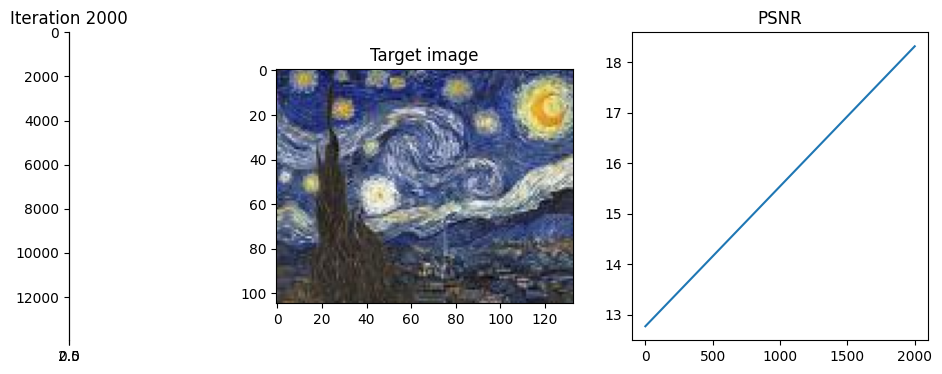

Iteration 4000  Loss: 0.0126  PSNR: 19.00 Time: 0.00 secs per iter 6.15 secs in total


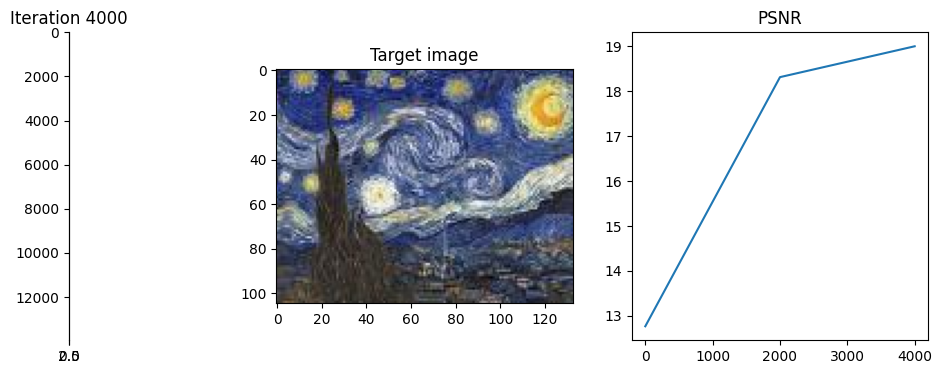

Iteration 6000  Loss: 0.0115  PSNR: 19.38 Time: 0.00 secs per iter 9.62 secs in total


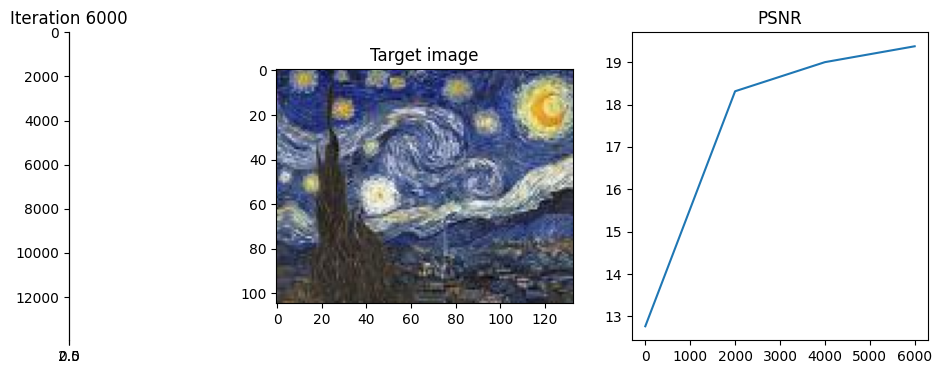

Iteration 8000  Loss: 0.0110  PSNR: 19.59 Time: 0.00 secs per iter 12.62 secs in total


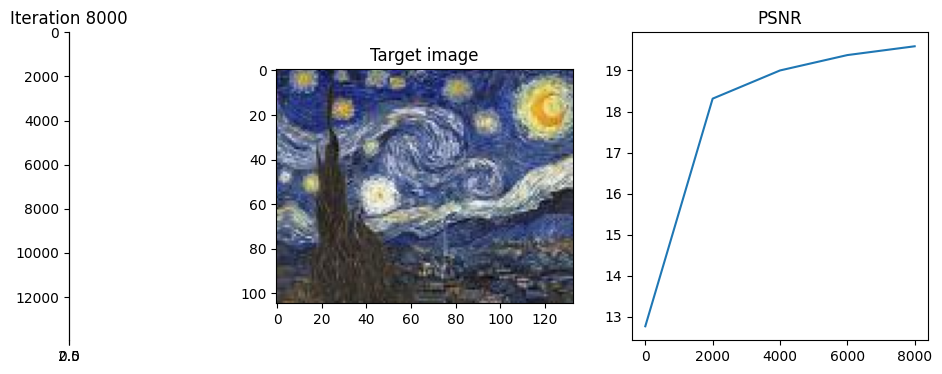

Iteration 10000  Loss: 0.0107  PSNR: 19.72 Time: 0.00 secs per iter 15.67 secs in total


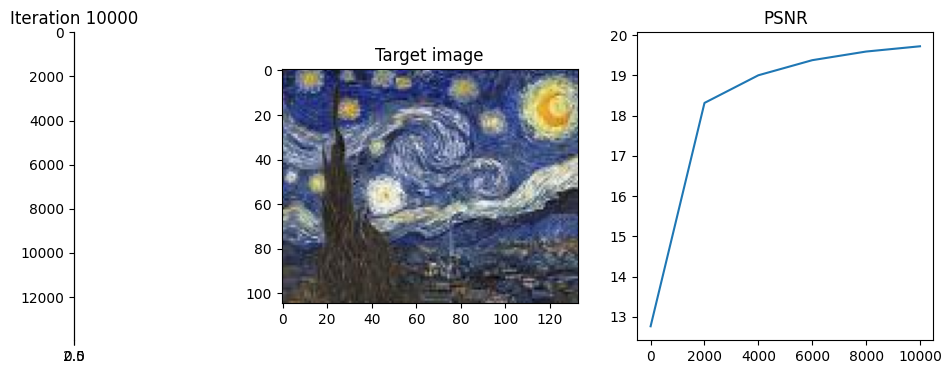

Done!


In [29]:
# no positional encoding
train_2d_model(model=Model2d, num_frequencies=0)

Iteration 0  Loss: 0.0678  PSNR: 11.69 Time: 0.00 secs per iter 0.01 secs in total


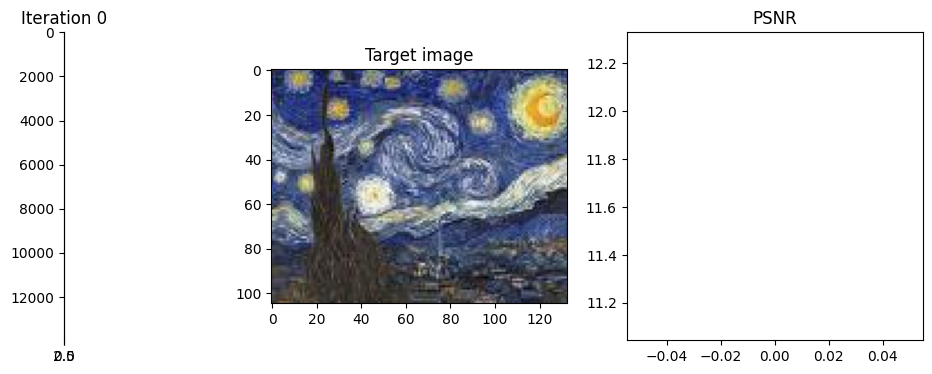

Iteration 2000  Loss: 0.0053  PSNR: 22.80 Time: 0.00 secs per iter 3.04 secs in total


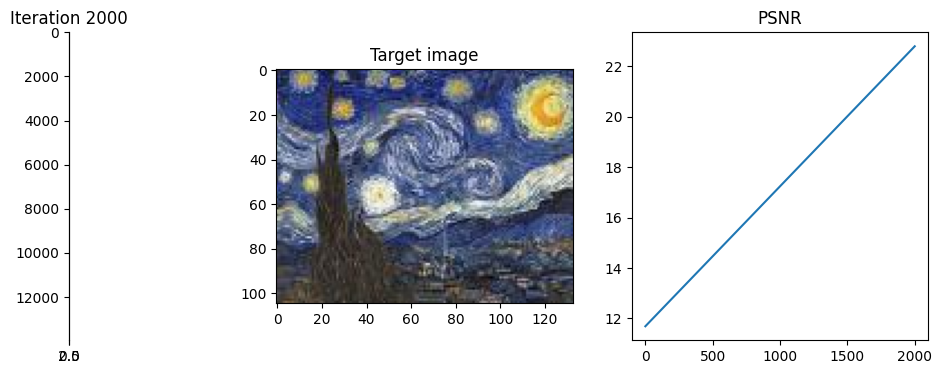

Iteration 4000  Loss: 0.0043  PSNR: 23.67 Time: 0.00 secs per iter 6.49 secs in total


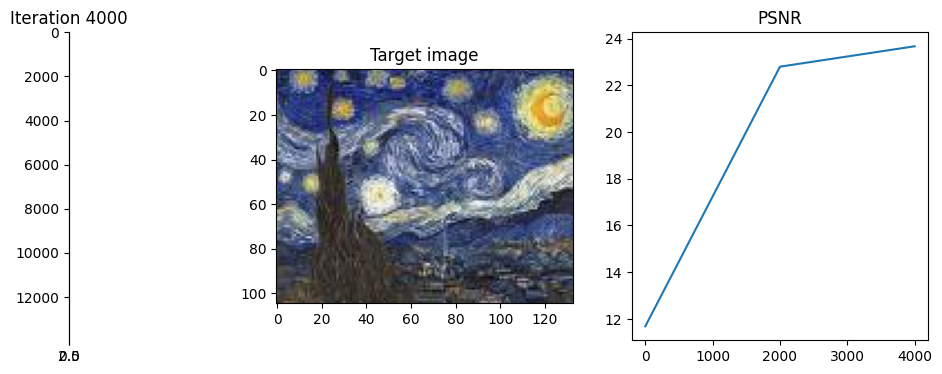

Iteration 6000  Loss: 0.0038  PSNR: 24.19 Time: 0.00 secs per iter 9.53 secs in total


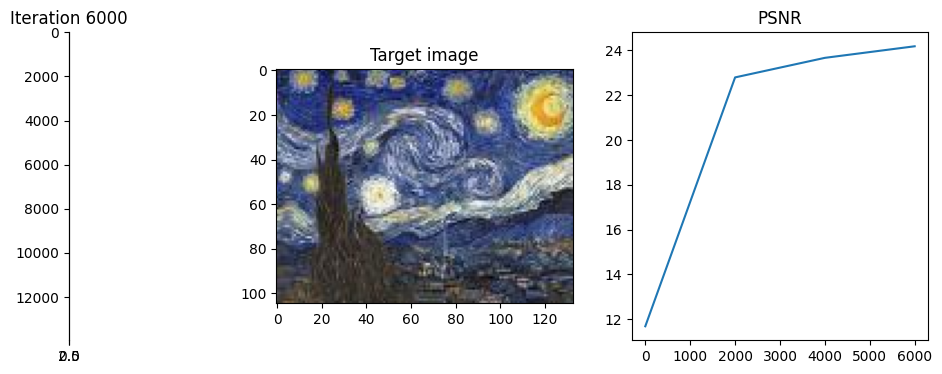

Iteration 8000  Loss: 0.0035  PSNR: 24.52 Time: 0.00 secs per iter 12.55 secs in total


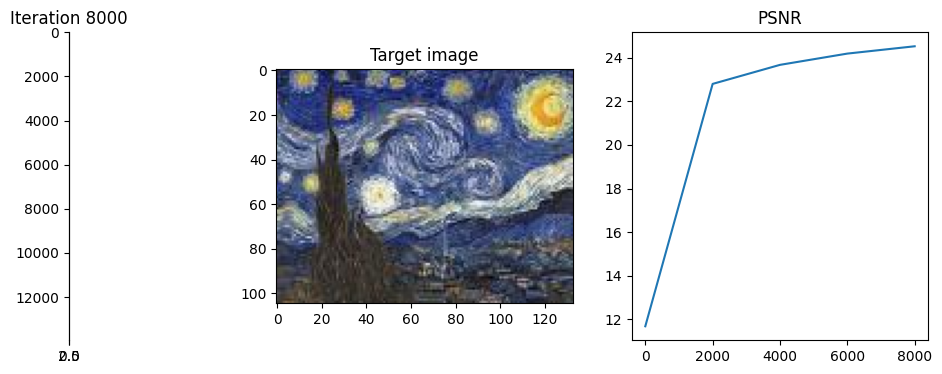

Iteration 10000  Loss: 0.0033  PSNR: 24.80 Time: 0.00 secs per iter 15.68 secs in total


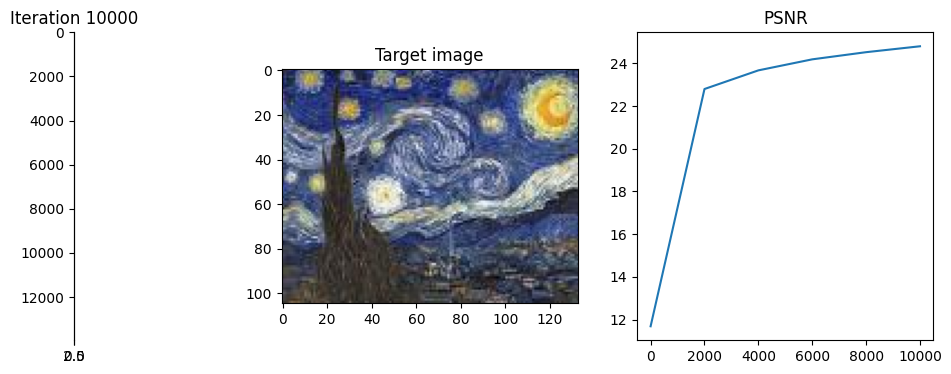

Done!


In [30]:
# with positional encoding at frequency=3
train_2d_model(model=Model2d, num_frequencies=3)

--------------(the end of TODO 1)---------------

# Neural Radiance Field Scene Representation

A simplified version of NeRF represents a continous scene as a function using the following MLP network, whose input is a 3D location $\mathbf{x}=(x,y,z)$ and whose output is an RGB color $\mathbf{c}=(r,g,b)$ and volume density $\sigma$ at that 3D location.


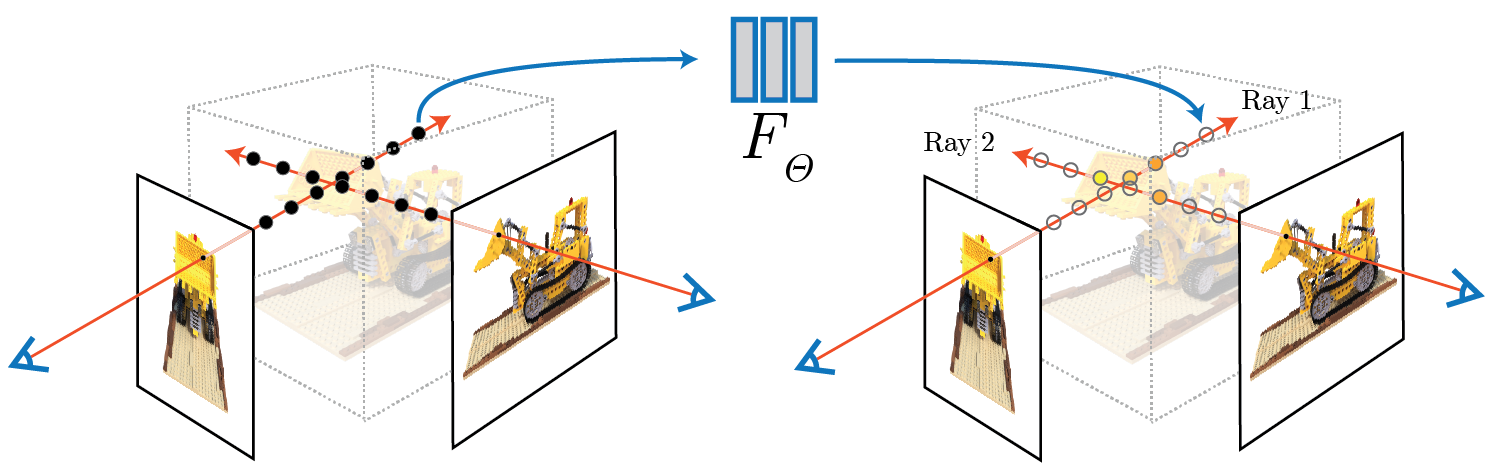

# Student TODO implementations 2, 3, 4: Volume Rendering with Radiance Fields
A neural radiance field represents a scene as the volume density $\sigma$ and the RGB color $\bf c$ at any point in space. We can render an image from this neural radiance field by estimating the color at each pixel in the image by shooting a camera ray from through that pixel through the scene, and accumulating color and density along the way.

Rendering an image from neural radiance fields consists of three steps:
1. TODO 2: given camera parameters, compute the origin and the direction of the camera ray through each pixel of the image in the world coordinate frame
2. TODO 3: sample points along each camera ray and compute the sampled 3D points coordinates
3. TODO 4: composite the colors and densities of the sampled points along a camera ray to get the final color of pixel

## Dataset
For TODO 2-5 you will be using the lego dataset. The lego dataset contains 100 training images and 1 test image, captured from viewpoints sampled on a upper hemisphere around the object looking towards a Lego bulldozer. The figure below shows some images from  this dataset.

Run the script below to download the lego dataset, load images and camera poses, and display the test image.



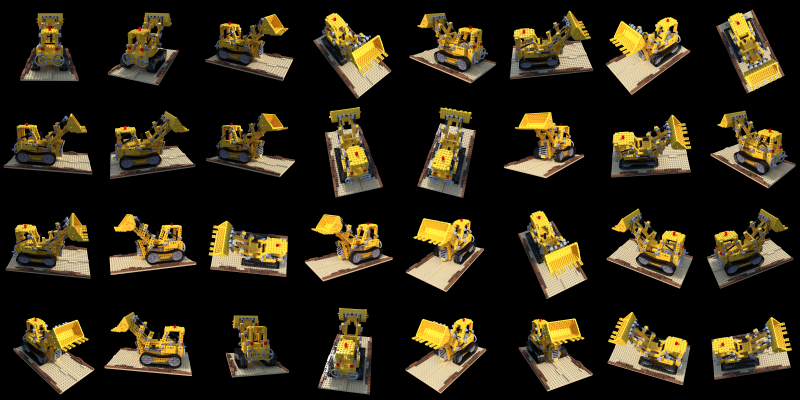

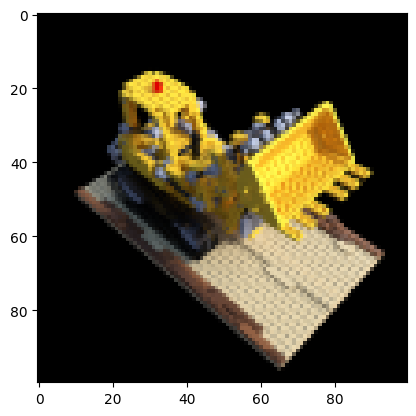

In [31]:
# Download the lego dataseet and painting
import os
if not os.path.exists('lego_data_update.npz'):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/lego_data_update.npz

# Load input images, poses, and intrinsics
data = np.load("lego_data_update.npz")

# Images
images = data["images"]

# Height and width of each image
height, width = images.shape[1:3]

# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)

# Camera intrinsics
cam_intrinsics = data["intrinsics"]
cam_intrinsics = torch.from_numpy(cam_intrinsics).to(device)

# Near and far clipping thresholds for depth values.
near_thresh = 0.667
far_thresh = 2.

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Rest images form test set
testset, testsetpose = images[101:], tform_cam2world[101:]
testset = torch.from_numpy(testset).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

plt.imshow(testimg.detach().cpu().numpy())
plt.show()

## TODO 2: Compute the origin and direction of rays through all pixels of an image.

The goal of this TODO is to compute the origin and the direction of camera ray through each pixel of the image in the world coordinate space. This part is very related to the concepts you learned in [Lecture 10](https://www.cs.cornell.edu/courses/cs5670/2022sp/lectures/lec10_cameras_for_web.pdf) (please review this lecture first if you have forgotten the details). In Lecture 10, we showed you how to project (x, y, z) points in world coordinates into a camera -- This TODO is almost the inversion of this process. You may follow the steps below:

1. Get the all pixel coordinates in the image space (shape: `[height, width, 2])`. Each 2D coordinate is (x, y), where x is the index along the horizontal axis, and y is the index along the vertical axis.
2. Transform image coordinates into camera coordinates using the camera intrinsics $𝐊$. You should first turn each pixel coordinate (x, y) into homogeneous coordinates (x, y, 1) and then apply $𝐊$ in some way. Remember that $𝐊$ transforms camera coordinates into image coordinates, while here you are supposed to do the opposite.
3. In fact, the coordinates you computed in step 2 are exactly the directions of each ray in the camera coordinate space, because they can be viewed as a vector starting from the camera origin (0, 0, 0). Your task is to convert both the camera origin, and the direction of each ray to the world coordinate frame. You should use our provided camera to world transformation matrix `tform_cam2world`.


***Note: in the function `get_rays()`, you are not allowed to use for loops. Instead, you should use pytorch vectorized functions (such as torch.meshgrid, torch.matmul, torch.stack) to ensure efficient code.***



In [32]:
def get_rays(height, width, intrinsics, tform_cam2world):
  r"""Compute the origin and direction of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): the height of an image.
    width (int): the width of an image.
    intrinsics (torch.Tensor): Camera intrinsics matrix of shape (3, 3).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera coordinate space to the world frame coordinate space.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(height, width, 3)` denoting the centers of
      each ray. Note that desipte that all ray share the same origin,
      here we ask you to return the ray origin for each ray as (height, width, 3).
    ray_directions (torch.Tensor): A tensor of shape :math:`(height, width, 3)` denoting the
      direction of each ray.
  """
  device = tform_cam2world.device
  ray_directions = torch.zeros((height, width, 3), device=device)  # placeholder
  ray_origins = torch.zeros((height, width, 3), device=device)  # placeholder
  #############################  TODO 2 BEGIN  ##########################
  if tform_cam2world.shape == (3, 4):
        tform_cam2world = torch.cat(
            [tform_cam2world, torch.tensor([[0, 0, 0, 1.0]], device=device, dtype=tform_cam2world.dtype)],
            dim=0
        )

  coords_y, coords_x = torch.meshgrid(
      torch.arange(height, device=device, dtype=torch.float32),
      torch.arange(width, device=device, dtype=torch.float32), indexing='ij'
  )
  image_coords = torch.stack((coords_x, coords_y, torch.ones_like(coords_x)), dim=-1)

  cam_dirs = (torch.linalg.inv(intrinsics) @ image_coords.reshape(-1, 3).T).T  # (H*W, 3)
  cam_dirs = cam_dirs / cam_dirs[..., 2:3]  # normalize homogeneous coords

  # assign results
  ray_origin = tform_cam2world[:3, 3]
  ray_origins = ray_origin.expand(height, width, 3)

  # rot @ camera direction vector
  ray_directions = (tform_cam2world[:3, :3] @ cam_dirs.T).T.reshape(height, width, 3)
  #############################  TODO 2 END  ############################
  return ray_origins, ray_directions

### Test case for TODO 2
test function `get_rays()`

In [33]:
THRESH = 1e-2
if not os.path.exists("get_rays_test_0.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/get_rays_test_0.npz
if not os.path.exists("get_rays_test_1.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/get_rays_test_1.npz

def test_get_rays(test_file):
    test_data = np.load(test_file)
    h, w = int(test_data['h']), int(test_data['w'])
    intrinsics = test_data['intrinsics']
    pose = test_data['pose']
    ray_o_predict, ray_d_predict = get_rays(h, w, torch.from_numpy(intrinsics), torch.from_numpy(pose))
    error_ray_o = np.mean((test_data['ray_o'] - ray_o_predict.numpy())**2)
    error_ray_d = np.mean((test_data['ray_d'] - ray_d_predict.numpy())**2)

    assert (error_ray_o < THRESH) and (error_ray_d < THRESH)
    print("Passed!")

test_get_rays("get_rays_test_0.npz")
test_get_rays("get_rays_test_1.npz")

Passed!
Passed!


## TODO 3: Sample the 3D points on the camera rays.

Given the origin $𝐨$ and the direction $𝐝$ of a ray, we want to sample 3D points $𝐱$ on this ray. The sampling range is bounded by the near and far threshold, denoted as $t_n, t_f$. In order to ensure the ray to be thoroughly sampled during training, we evenly partition the ray into $N$ bins and uniformly sample one point in each bin.

$$𝐱_i=𝐨 + t_i𝐝$$
$$t_i ∼ 𝑼[t_n+\frac{i-1}{N}(t_f-t_n), t_n+\frac{i}{N}(t_f-t_n)]$$

where $t_i, i=\{1,\cdots,N\}$ is the sampled depth value.

In the function of `sample_points_from_rays`, there is an argument called `randomize`. When `randomize` is `True`, you should sample one point uniformly at random from each bin.
When `randomize` is `False`, you should instead sample the lower bound of each bin, i.e.,
$$t_i = t_n+\frac{i-1}{N}(t_f-t_n)$$

In [34]:
def sample_points_from_rays(
    ray_origins,
    ray_directions,
    near_thresh,
    far_thresh,
    num_samples,
    randomize = True
):
  r"""Sample 3D points on the given rays. The near_thresh and far_thresh
  variables indicate the bounds of sampling range.

  Args:
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_rays` method (shape: :math:`(height, width, 3)`).
    ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
      `get_rays` method (shape: :math:`(height, width, 3)`).
    near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
      coordinate that is of interest/relevance).
    far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
      coordinate that is of interest/relevance).
    num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
      randomly, whilst trying to ensure "some form of" uniform spacing among them.
    randomize (optional, bool): Whether or not to randomize the sampling of query points.
      By default, this is set to `True`. If disabled (by setting to `False`), we sample
      uniformly spaced points along each ray (i.e., the lower bound of each bin).

  Returns:
    query_points (torch.Tensor): Query 3D points along each ray
      (shape: :math:`(height, width, num_samples, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(height, width, num_samples)`).
  """
  device = ray_origins.device
  height, width = ray_origins.shape[:2]
  depth_values = torch.zeros((height, width, num_samples), device=device) # placeholder
  query_points = torch.zeros((height, width, num_samples, 3), device=device) # placeholder
  #############################  TODO 3 BEGIN  ##########################
  bins = torch.arange(num_samples, device=device)
  t = torch.zeros_like(bins, dtype=torch.float32, device=device)
  if randomize:
    bin_edges = torch.linspace(near_thresh, far_thresh, num_samples + 1, device=device)

    lower = bin_edges[:-1]
    upper = bin_edges[1:]
    t = lower + torch.rand(num_samples, device=device) * (upper - lower)

    t_reshaped = t.view(1, 1, -1)
    depth_values[:] = t_reshaped.repeat(height, width, 1)
  else:
    t[:] = near_thresh + (bins/num_samples)*(far_thresh - near_thresh)
    t_reshaped = t.view(1,1,-1)
    depth_values[:] = t_reshaped.repeat(height, width, 1)

  origins_extended = ray_origins.unsqueeze(2)
  directions_extended = ray_directions.unsqueeze(2)
  depths_extended = depth_values.unsqueeze(3)
  query_points = origins_extended + depths_extended@directions_extended


  #############################  TODO 3 END  ############################
  return query_points, depth_values

### Test case for TODO 3

test function `sample_points_from_rays()`

In [35]:
THRESH = 1e-2
if not os.path.exists("sample_points_from_rays_test_0.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/sample_points_from_rays_test_0.npz
if not os.path.exists("sample_points_from_rays_test_1.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/sample_points_from_rays_test_1.npz

def test_sample_points(test_file):
    test_data = np.load(test_file)
    near_thresh, far_thresh = float(test_data['near_thresh']), float(test_data['far_thresh'])
    num_samples = int(test_data['num_samples'])
    ray_origins = torch.from_numpy(test_data['ray_origins'])
    ray_directions = torch.from_numpy(test_data['ray_directions'])
    points, depth = sample_points_from_rays(ray_origins=ray_origins,
    ray_directions=ray_directions, near_thresh=near_thresh,
    far_thresh=far_thresh, num_samples=num_samples, randomize = False)

    error_points = np.mean((test_data['points'] - points.numpy())**2)
    error_depth = np.mean((test_data['depth'] - depth.numpy())**2)

    assert (error_points < THRESH) and (error_depth < THRESH)
    print("Passed!")

test_sample_points("sample_points_from_rays_test_0.npz")
test_sample_points("sample_points_from_rays_test_1.npz")

Passed!
Passed!


## TODO 4: Compute compositing weight of samples on camera ray (pre-step of volume rendering)

The expected color $C(𝐫)$ of camera ray 𝐫 in the continuous space can be computed with the formula:
$$C(𝐫)=\int_{t_n}^{t_f}T(t)\sigma(𝐫(t))𝐜(𝐫(t),𝐝)dt$$
where $T(t)=\text{exp}(-\int_{t_n}^{t}\sigma(𝐫(s))ds)$ denotes the accumulated transmittance along the ray from $t_n$ to $t$, i.e., the probability that the ray doesn't hit any other particle from $t_n$ to $t$.

To numerically and differentiably estimate this continous integral, we use a discrete set of samples with the quadrature rule as follows:
$$\hat{C}(𝐫)=\sum_{i=1}^{N}T_i(1-\text{exp}(-\sigma_iδ_i))𝐜_i$$
where N is the number of samples, $T_i=\text{exp}(-\sum_{j=1}^{i-1}\sigma_iδ_i)$, and $δ_i=t_{i+1}-t_i$ is the distance between adjacent samples. From sampled depth values $t_i, i=1,\cdots,N$, you can get distances $δ_i, i=1,\cdots,N-1$, and you should append a huge number $1e9$ as the last distance $δ_N$.

In the function `compute_compositing_weights` (TODO 4), your task is to compute the weight $w_i =  T_i(1-\text{exp}(-\sigma_iδ_i))$ for each query point. In TODO 6, you will be using the computed weights $w_i$ to composite $𝐜_i$ into a pixel color ($\hat{C}(𝐫)=\sum_{i=1}^{N}w_i𝐜_i$).

In [36]:
def compute_compositing_weights(sigma, depth_values):
  r"""Differentiably renders a radiance field, given the origin of each ray in the
  "bundle", and the sampled depth values along them.

  Args:
    sigma (torch.Tensor): Volume density at each query location (X, Y, Z)
      (shape: :math:`(height, width, num_samples)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(height, width, num_samples)`).

  Returns:
    weights (torch.Tensor): Rendered compositing weight of each sampled point
      (shape: :math:`(height, width, num_samples)`).
  """
  # helper function
  # Compute the cummulative product of the input array,
  # but excluse the current element
  # > cumprod_exclusive(torch.tensor([1,2,3,4,5]))
  # > tensor([ 1,  1,  2,  6, 24])
  def cumprod_exclusive(x):
    cumprod = torch.cumprod(x, -1)
    cumprod = torch.roll(cumprod, 1, -1)
    cumprod[..., 0] = 1.
    return cumprod

  device = depth_values.device
  weights = torch.ones_like(sigma, device=device) # placeholder
  #############################  TODO 4 BEGIN  ##########################
  # get the spacing between subsequent entries
  distance = depth_values[:, :, 1:] - depth_values[:, :, :-1]
  distance = torch.cat([distance, torch.ones_like(distance[:, :, :1]) * 1e9], dim=2)

  # calculate alpha and transmittance
  a = 1 - torch.exp(-sigma*distance)
  t = cumprod_exclusive(1 - a)

  weights = t * a

  #############################  TODO 4 END  ##########################
  return weights

### Test case for TODO 4
test function `compute_compositing_weights()`

In [37]:
import os
THRESH = 1e-2
if not os.path.exists("compute_composit_weights_test_0.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/compute_composit_weights_test_0.npz
if not os.path.exists("compute_composit_weights_test_1.npz"):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/compute_composit_weights_test_1.npz

def test_compute_compositing_weights(test_file):
    test_data = np.load(test_file)
    sigma = torch.from_numpy(test_data['sigma'])
    depth_values = torch.from_numpy(test_data['depth_values'])
    weights = compute_compositing_weights(sigma, depth_values)
    error_weights = np.mean((test_data['weights'] - weights.numpy())**2)
    assert error_weights < THRESH
    print("Passed!")

test_compute_compositing_weights("compute_composit_weights_test_0.npz")
test_compute_compositing_weights("compute_composit_weights_test_1.npz")

Passed!
Passed!


# Student TODO implementation 5: Define the NeRF model

Similar to the `Model2d` model for image fitting in TODO 1(b), a simplified version of NeRF model represents a continous scene as a function whose input is a 3D location $\mathbf{x}=(x,y,z)$ and whose output is an RGB color $\mathbf{c}=(r,g,b)$ and volume density $\sigma$ at that 3D location. Please implement the `NerfModel` below, which is an MLP with 8 layers:
- The input layer takes in a positional-encoded 3D coordinate $\mathbf{x}$, projecting it to the hidden dimension with ReLU activation.
- Three subsequent hidden layers with the same input and output hidden dimension with ReLU activation.
- The 5th layer adopts a **skip connection** design, whose input is the concatenation of the positional-encoded 3D coordinate $\mathbf{x}$ (the initial input) and the output of the 4th layer, projecting it to the hidden dimension with ReLU activation.
- Two subsequent hidden layers with the same input and output hidden dimension with ReLU activation.
- The output layer projects the hidden dimension to a 4D vector, which is the RGB color $\mathbf{c}=(r,g,b)$ and volume density $\sigma$ at that 3D location. The RGB color should be activated with a sigmoid function for a $(0, 1)$ range, while the volume density $\sigma$ should be activated with a ReLU function for a $[0, +\infty)$ range.

In [38]:
class NerfModel(nn.Module):
  r"""Define a NeRF model comprising eight fully connected layers with a skip connection after the 4th layer.
  """
  def __init__(self, in_channels, filter_size=256):
    super().__init__()
  #############################  TODO 5(a) BEGIN  ############################

    self.layer1 = nn.Linear(in_channels, filter_size)
    self.layer2 = nn.Linear(filter_size, filter_size)
    self.layer4 = nn.Linear(filter_size, filter_size)
    self.layer3 = nn.Linear(filter_size, filter_size)

    self.layer5 = nn.Linear(filter_size + filter_size, filter_size)
    self.layer6 = nn.Linear(filter_size, filter_size)
    self.layer7 = nn.Linear(filter_size, filter_size)
    self.layer8 = nn.Linear(filter_size, 4)

    self.relu = nn.ReLU()
    # self.sigmoid = nn.Sigmoid()

  #############################  TODO 5(a) END  ############################

  def forward(self, x):
  #############################  TODO 5(b) BEGIN  ############################
    out1 = self.relu(self.layer1(x))
    out2 = self.relu(self.layer2(out1))
    out3 = self.relu(self.layer3(out2))
    out4 = self.relu(self.layer4(out3))

    # skip connect at layer 3
    skip = torch.cat([out4, out3], dim=1)
    out5 = self.relu(self.layer5(skip))
    out6 = self.relu(self.layer6(out5))
    out7 = self.relu(self.layer7(out6))

    out8 = self.layer8(out7)

    # sigmoid on rgb
    out8[..., :3] = torch.sigmoid(out8[..., :3])
    # relu on volume density
    out8[..., 3:] = F.relu(out8[..., 3:])

    return out8

    pass
  #############################  TODO 5(b) END  ############################

# Student TODO implementation 6: render one image with NeRF
To render an image with NeRF, we will combine the previous TODO implemenations in the following steps:
1. compute the camera rays (TODO 2)
2. sample 3D points on rays (TODO 3)
3. positionally encode the sampled points (TODO 1(a))
4. feed the encoded points into the network (`model`, TODO 5) to compute the color and volume density $\sigma$ for each point
5. use volume density $\sigma$ to compute the compositing weights of samples on a ray (TODO 4)
6. compute the pixel color by integrating colors of all samples along a ray, i.e. weighted sum of the color value according to the compositing weight as below
$$\hat{C}(𝐫)=\sum_{i=1}^{N}w_i𝐜_i$$
This will allow us to render a final RGB image. To render a depth map instead, simply replace colors to sampled depth values, i.e., $\hat{D}(𝐫)=\sum_{i=1}^{N}w_it_i$.

In [39]:
def render_image_nerf(height, width, intrinsics, tform_cam2world,
                      near_thresh, far_thresh, depth_samples_per_ray,
                      encoding_function, model, rand=False):

  def get_minibatches(inputs, chunksize = 1024 * 32):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i:i + chunksize] for i in range(0, inputs.shape[0], chunksize)]



  #############################  TODO 6 BEGIN  ##########################
  # Get the direction and origin of rays through all image pixels. (TODO 2)

  # Sample 3D points along each ray (TODO 3)

  # Encode the query points with encoding_function (default: positional encoding TODO 1(a)).

  # Split the encoded points into "chunks" (you may use the helper function
  # "get_minibatches" for this), run the model on all chunks, and concatenate
  # the results. Splitting into chunks helps avoid out-of-memory issues.
  # e.g.
  # chunksize = 1024 * 32
  # batches = get_minibatches(input, chunksize=chunksize)
  # output = []
  # for batch in batches:
  #   output.append(model(batch))
  # output = torch.cat(output, dim=0)

  # Perform differentiable volume rendering to re-synthesize the RGB image. (TODO 4)

  ray_origins, ray_directions = get_rays(height, width, intrinsics, tform_cam2world)
  ray_origins = ray_origins.to(device)
  ray_directions = ray_directions.to(device)

  points, depth = sample_points_from_rays(ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray, rand)
  points = points.to(device)
  depth = depth.to(device)

  pos_encoding = encoding_function(points.reshape(-1, 3))
  pos_encoding.to(device)

  chunksize = 1024 * 32
  batches = get_minibatches(pos_encoding, chunksize=chunksize)
  output = []
  for batch in batches:
    output.append(model(batch))
  output = torch.cat(output, dim=0)
  rgb_predicted = output[..., :3]
  sigma_predicted = output[..., 3:4]

  sigma_predicted = sigma_predicted.reshape(height, width, depth_samples_per_ray)
  rgb_predicted = rgb_predicted.reshape(height, width, depth_samples_per_ray, 3)

  weights = compute_compositing_weights(sigma_predicted, depth)
  rgb_predicted = torch.sum(weights.unsqueeze(-1) * rgb_predicted, dim=2)
  depth_predicted = torch.sum(weights * depth, dim=2)



  #############################  TODO 6 END  ##########################

  return rgb_predicted, depth_predicted

## Test case for TODO 6

Passed!


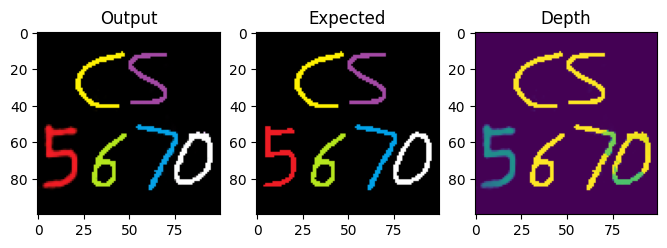

In [40]:


if not os.path.exists('render_image_test.pt'):
    !wget https://www.cs.cornell.edu/courses/cs5670/2022sp/projects/pa5/render_image_test.pt

def render_image_test(ckpt_path):
  ckpt = torch.load(ckpt_path, map_location='cpu')
  encode = lambda x: positional_encoding(x, num_frequencies=6)
  model_test5 = NerfModel(in_channels=39)
  model_test5.load_state_dict(ckpt['model_state_dict'])
  model_test5.to(device)
  test_intrinsics = ckpt['intrinsics'].to(device)
  tform_cam2world = ckpt['tform_cam2world'].to(device)
  groundtruth = ckpt['gt'].to(device)

  with torch.no_grad():
    rgb_predicted, depth_predicted = render_image_nerf(
                                      100, 100, test_intrinsics,
                                      tform_cam2world, 0.667,
                                      2.0, 64,
                                      encode, model_test5)

  # Test according to MSE criterion
  assert F.mse_loss(rgb_predicted, groundtruth) < 0.003
  print("Passed!")

  plt.figure(figsize=(8, 4))
  plt.subplot(131)
  plt.imshow(rgb_predicted.detach().cpu().numpy())
  plt.title(f"Output")
  plt.subplot(132)
  plt.imshow(groundtruth.cpu().numpy())
  plt.title("Expected")
  plt.subplot(133)
  plt.imshow(depth_predicted.detach().cpu().numpy())
  plt.title("Depth")
  plt.show()

render_image_test('render_image_test.pt')

# Student TODO implementation 7: Train a NeRF on 360 scene
If you passed all tests, you can start training the NeRF! Please complete the missing parts in the following training code, including:
1. Model and optimizer definition before training (TODO 7 (a))
2. Training step at each iteration (TODO 7 (b))
   1. Randomly pick a training image from the dataset as the target image (Hint: use the `images` and `tform_cam2world` variables from the previous stages as the training dataset).
   2. Render the image with NeRF (TODO 6) and compute the loss function (MSE).
   3. Backpropagate the loss and update the model parameters.
3. Eval step every `display_every` iterations (TODO 7 (c))
   1. Render the image with NeRF (TODO 6) from the test pose (`testpose` variable).
   2. Compute the MSE loss and PSNR between the rendered image and the ground truth image (`testimg` variable).

Expect to reach PSNR greater than or equal to 20 after training for 1,000 iterations with num_encoding_functions=6.

Small note: The training can get stuck at local optimum with certain initialization, in which can the PSNR will not improve with more training. You can rerun the code to restart training.

Iteration 0  Loss: 0.1243  PSNR: 9.05  Time: 0.01 secs per iter,  0.01 mins in total


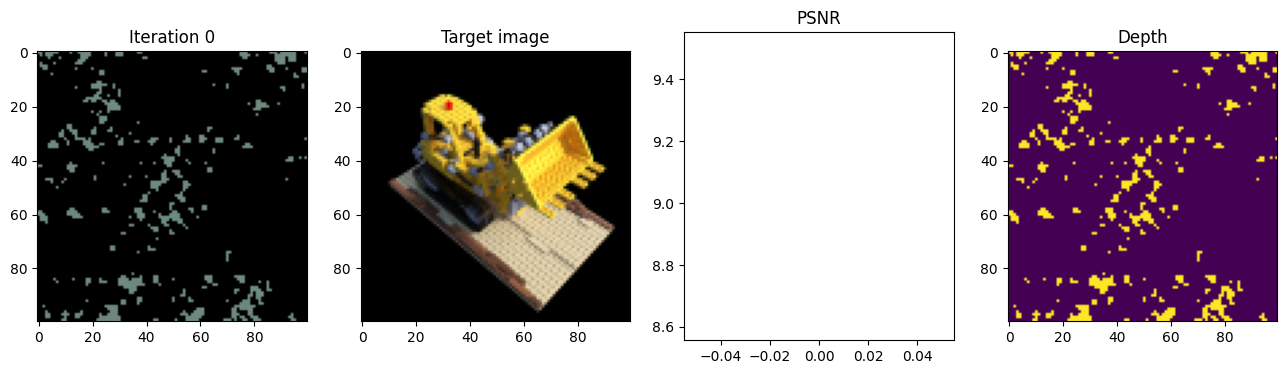

Iteration 100  Loss: 0.0659  PSNR: 11.81  Time: 0.69 secs per iter,  1.16 mins in total


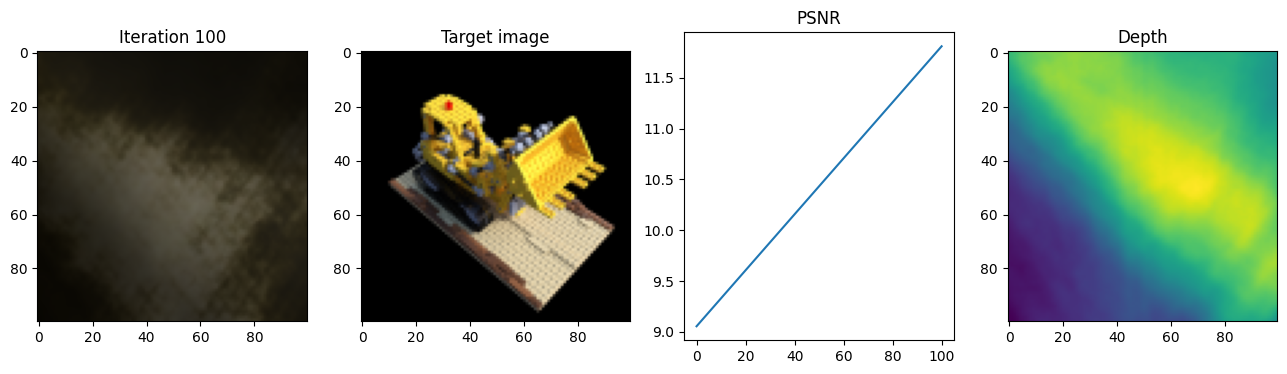

Iteration 200  Loss: 0.0212  PSNR: 16.74  Time: 0.67 secs per iter,  2.28 mins in total


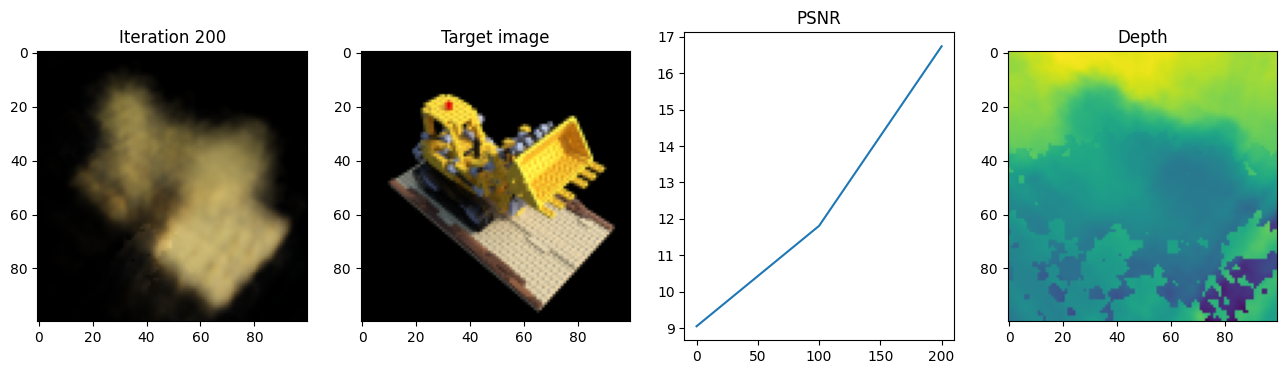

Iteration 300  Loss: 0.0131  PSNR: 18.82  Time: 0.64 secs per iter,  3.35 mins in total


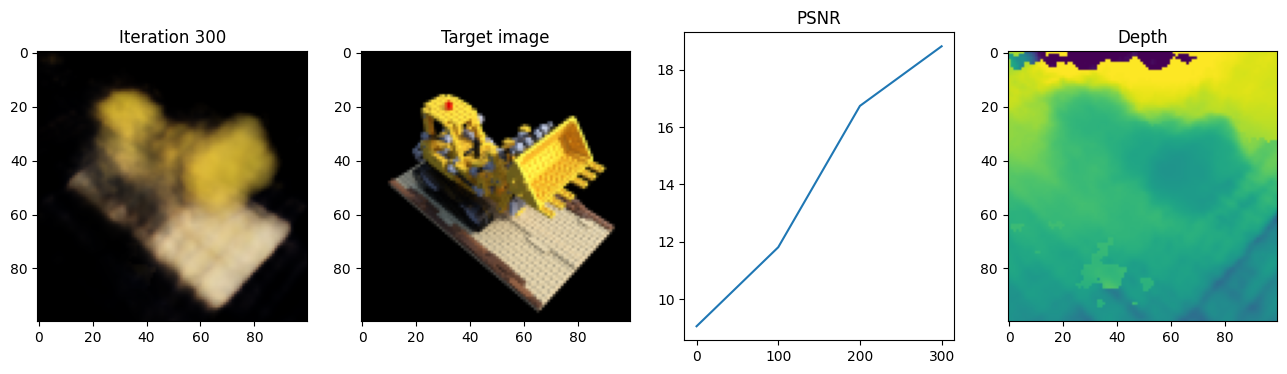

Iteration 400  Loss: 0.0110  PSNR: 19.60  Time: 0.64 secs per iter,  4.41 mins in total


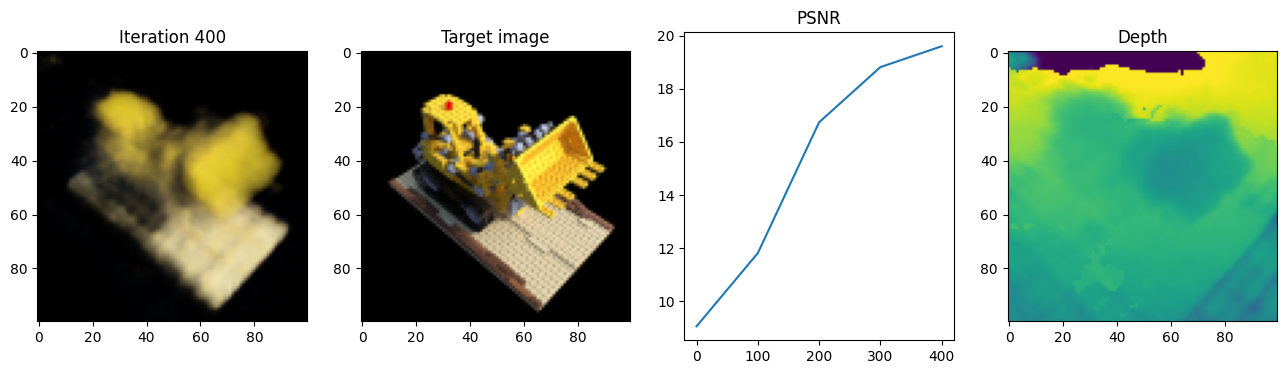

Iteration 500  Loss: 0.0097  PSNR: 20.12  Time: 0.63 secs per iter,  5.47 mins in total


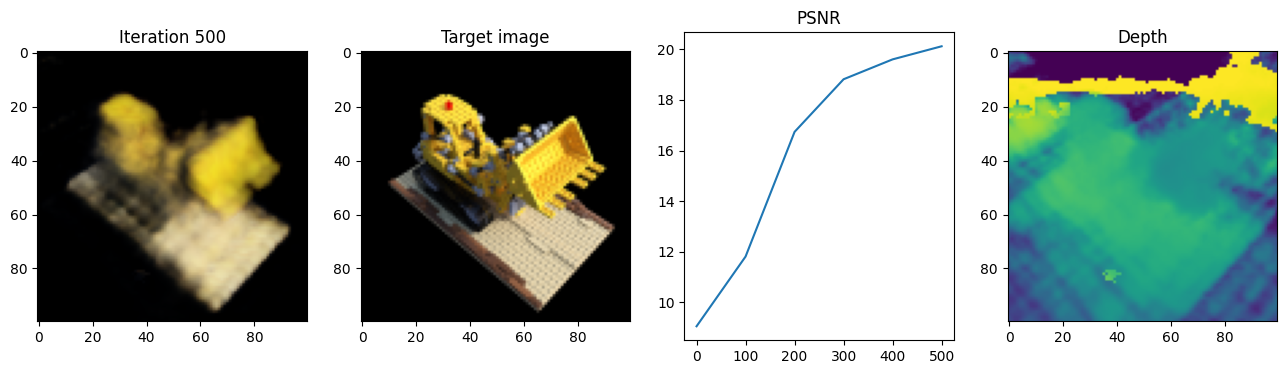

Iteration 600  Loss: 0.0098  PSNR: 20.08  Time: 0.63 secs per iter,  6.52 mins in total


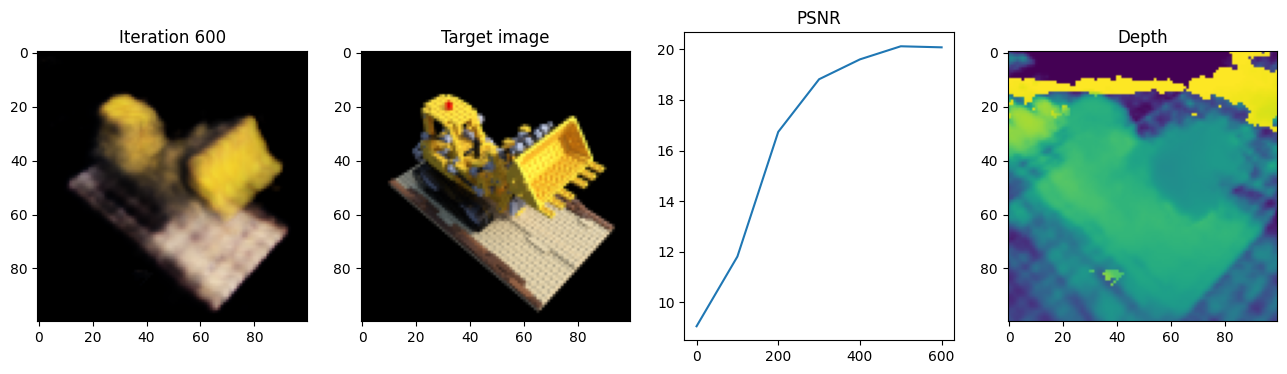

Iteration 700  Loss: 0.0079  PSNR: 21.01  Time: 0.63 secs per iter,  7.56 mins in total


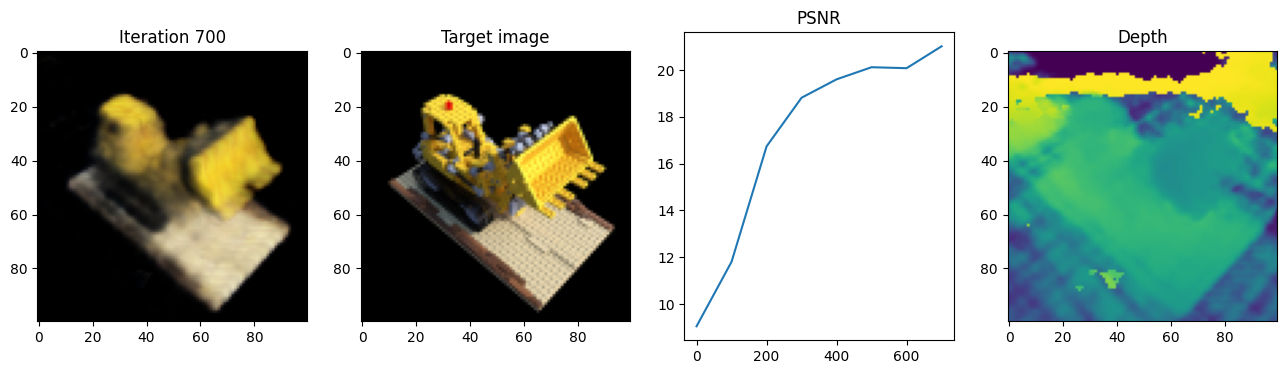

Iteration 800  Loss: 0.0082  PSNR: 20.86  Time: 0.63 secs per iter,  8.61 mins in total


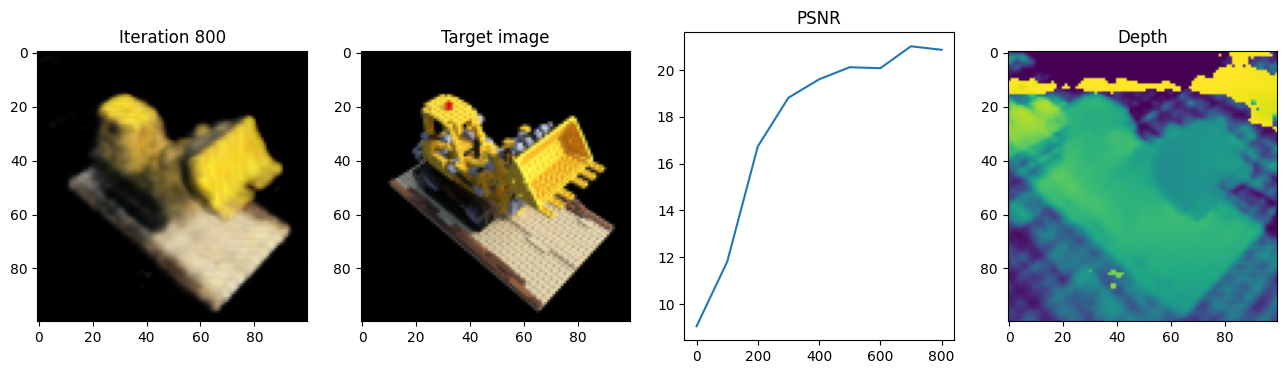

Iteration 900  Loss: 0.0078  PSNR: 21.10  Time: 0.63 secs per iter,  9.65 mins in total


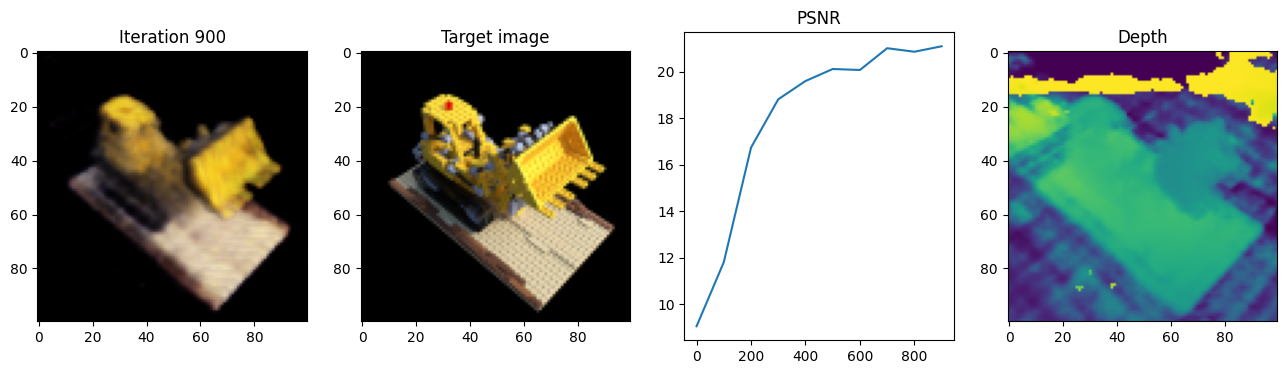

Iteration 1000  Loss: 0.0083  PSNR: 20.81  Time: 0.63 secs per iter,  10.70 mins in total


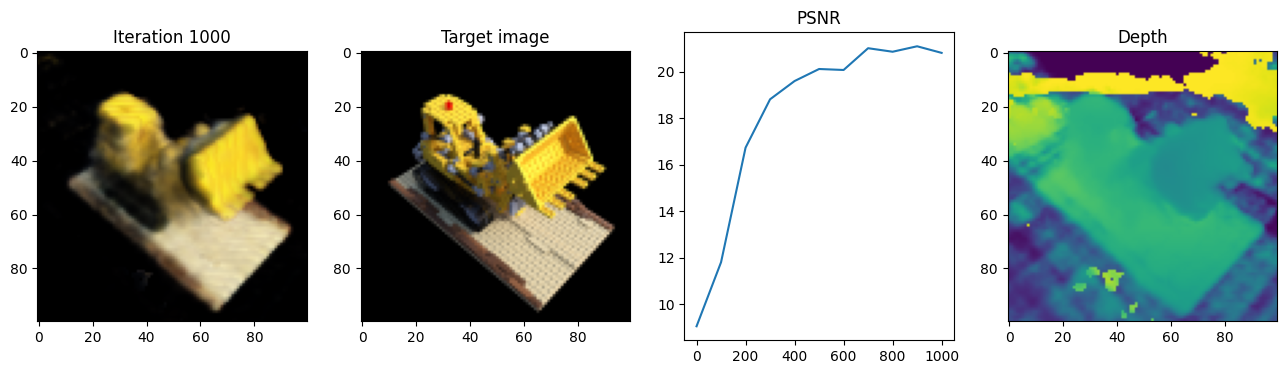

Done!


In [41]:
"""
Training NeRF
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_frequencies = 6
# Specify encoding function.
encode = lambda x: positional_encoding(x, num_frequencies=num_frequencies)
encode_channels = num_frequencies * 2 * 3 + 3
# Number of depth samples along each ray.
depth_samples_per_ray = 64

# todo: add time
# Seed RNG, for repeatability
seed = 5670
torch.manual_seed(seed)
np.random.seed(seed)

# Optimizer parameters
lr = 5e-4
num_iters = 1000

# Misc parameters
display_every = 100  # Number of iters after which stats are displayed

def weights_init(m):
  """Helper function to initialize NeRF model weights."""
  if isinstance(m, torch.nn.Linear):
    torch.nn.init.xavier_uniform_(m.weight)

#############################  TODO 7 (a) BEGIN  ############################
# Define the NeRF model and initialize its weights
model = None # Placeholder for the NeRF model
model = NerfModel(in_channels=encode_channels).to(device)
model.apply(weights_init)


# Define the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

model.train()

#############################  TODO 7 (a) END  ############################

"""
Train-Eval-Repeat!
"""
# Seed RNG, for repeatability
seed = 5672
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

t = time.time()
t0 = time.time()
for i in range(num_iters+1):
  #############################  TODO 7 (b) BEGIN  ############################

  pick_rand_image = random.randint(0, len(images)-1)
  image = images[pick_rand_image]
  transform = tform_cam2world[pick_rand_image]
  rgb_predicted, depth_predicted = render_image_nerf(height, width, cam_intrinsics,
                                                     transform , near_thresh, far_thresh,
                                                     depth_samples_per_ray, encode, model)
  loss = F.mse_loss(rgb_predicted, image)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  # psnr = 10. * torch.log10(1.0/loss)
  #############################  TODO 7 (b) END  ############################

  # Display images/plots/stats
  if i % display_every == 0:
    #############################  TODO 7 (c) BEGIN  ############################
    # Hint: Use `with torch.no_grad()` for faster performance during evaluation.
    with torch.no_grad():
      rgb_predicted, depth_predicted = render_image_nerf(height, width, cam_intrinsics,
                                                     testpose, near_thresh, far_thresh,
                                                     depth_samples_per_ray, encode, model)
    loss = F.mse_loss(rgb_predicted, testimg)
    psnr = 10. * torch.log10(1.0/loss)

    #############################  TODO 7 (b) END  ############################
    print("Iteration %d " % i, "Loss: %.4f " % loss.item(), "PSNR: %.2f " % psnr.item(), \
            "Time: %.2f secs per iter, " % ((time.time() - t) / display_every), "%.2f mins in total" % ((time.time() - t0)/60))
    t = time.time()
    psnrs.append(psnr.item())
    iternums.append(i)

    plt.figure(figsize=(16, 4))
    plt.subplot(141)
    plt.imshow(rgb_predicted.detach().cpu().numpy())
    plt.title(f"Iteration {i}")
    plt.subplot(142)
    plt.imshow(testimg.detach().cpu().numpy())
    plt.title("Target image")
    plt.subplot(143)
    plt.plot(iternums, psnrs)
    plt.title("PSNR")
    plt.subplot(144)
    plt.imshow(depth_predicted.detach().cpu().numpy())
    plt.title("Depth")
    plt.show()

print('Done!')

## Interactive visualization
Training finished!

In [42]:
trans_t = lambda t : np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=np.float32)

rot_phi = lambda phi : np.array([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=np.float32)

rot_theta = lambda th : np.array([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=np.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    c2w = c2w @ np.array([[1,0,0,0],[0,-1,0,0],[0,0,-1,0],[0,0,0,1]])
    c2w = np.array(c2w, dtype=np.float32)
    return c2w

%matplotlib inline
from ipywidgets import interactive, widgets
def f(**kwargs):
    render_poses = torch.from_numpy(pose_spherical(**kwargs)).to(device)
    rgb_predicted, _ = render_image_nerf(height, width, cam_intrinsics,
                                              render_poses[:3,:4], near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, model)
    img = np.clip(rgb_predicted.detach().cpu().numpy(),0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [1.5, 1., 2.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Test cases after training
## Run these blocks to evaluate novel view synthesis results from NeRF



## Qualitative evaluation
Create a 360 video with the trained NeRF by rendering a set of images around the object. Evaluate the novel view synthesis results qualitatively.
***Save your video and push the video to your github repository.***

In [43]:
import imageio
# 360 video
import tqdm

with torch.no_grad():
  rgbs = []
  for th in tqdm.tqdm(np.linspace(0., 360., 120, endpoint=False)):
      render_poses = torch.from_numpy(pose_spherical(th, -30., 1.4)).to(device)
      rgb_predicted, _ = render_image_nerf(height, width, cam_intrinsics,
                                              render_poses[:3,:4], near_thresh,
                                              far_thresh, depth_samples_per_ray,
                                              encode, model)
      rgbs.append(rgb_predicted.detach().cpu().numpy())
rgbs = np.array(rgbs)
print('Done, saving', rgbs.shape)
moviebase = os.path.join('{}_spiral_{:06d}_'.format("lego", num_iters))
to8b = lambda x : (255*np.clip(x,0,1)).astype(np.uint8)
imageio.mimwrite(moviebase + 'rgb.mp4', to8b(rgbs), fps=30, quality=8)

from IPython.display import HTML
from base64 import b64encode
mp4 = open(moviebase + 'rgb.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

100%|██████████| 120/120 [00:31<00:00,  3.81it/s]


Done, saving (120, 100, 100, 3)


## Quantitive results
Evaluate the novel view synthesis results quantitatively on the test set with PSNR metric. Expect to reach PSNR greater than or equal to 20.

In [44]:
psnrs = []
for i in range(testset.shape[0]):
  with torch.no_grad():
    rgb_predicted, depth_predicted = render_image_nerf(height, width, cam_intrinsics,
                                            testsetpose[i], near_thresh,
                                            far_thresh, depth_samples_per_ray,
                                            encode, model)
  loss = F.mse_loss(rgb_predicted, testset[i])
  psnr = -10. * torch.log10(loss)
  psnrs.append(psnr.item())
print("PSNR on test set: %.2f" % np.mean(np.array(psnrs)))

PSNR on test set: 22.45
